In [1]:
# %pip install opencv-python-headless
# %pip install keras
# %pip install tensorflow

In [1]:
import os
#os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,70).__str__()
import cv2 # import after setting OPENCV_IO_MAX_IMAGE_PIXELS
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import numpy as np

In [2]:
def plot_image(image_1, image_2,title_1="Orignal",title_2="New Image"):
    plt.figure(figsize=(10,10))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB))
    plt.title(title_1)
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB))
    plt.title(title_2)
    plt.show()

# U-net Multiclass

In [23]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda



################################################################
def multi_unet_model(n_classes=3, IMG_HEIGHT=100, IMG_WIDTH=100, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    p5 = MaxPooling2D(pool_size=(2, 2))(c5)
     
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
    c6 = Dropout(0.3)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    #Expansive path
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c5])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c4])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c3])
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
    u10 = concatenate([u10, c2])
    c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
    c10 = Dropout(0.1)(c10)
    c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
     
    u11 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
    u11 = concatenate([u11, c1], axis=3)
    c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
    c11 = Dropout(0.1)(c11)
    c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c11)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    
    return model
 

In [4]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

# converts images into NumPy arrays

In [25]:
LIMIT_BATCH_SIZE = 1000
available_indices = []
train_images = []
train_masks = []
path1 = os.path.abspath('../')
images_path = os.path.join(path1, "grid_images/train/", "*.png")
images_mask_path = os.path.join(path1, "grid_images/mask")
for filename in sorted(glob.glob(images_path))[:LIMIT_BATCH_SIZE]:
    img = cv2.imread(filename, 0)
    if img is None:
        print(f"Warning: Could not load image {filename}. Skipping.")
        continue
    temp = os.path.basename(filename).split("_")
    index = int(temp[1])
    temp = temp[1:]
    temp = "mask_patch_" + "_".join(temp)
    temp = os.path.join(images_mask_path, temp)
    
    if not os.path.exists(temp):
        continue
    train_images.append(filename)
    train_masks.append(temp)
    available_indices.append(index)
print(f"Number of available indices: {len(available_indices)}")
print(f"Number of train images: {len(train_images)}")
print(f"Number of train masks: {len(train_masks)}")

#Resizing images, if needed
SIZE_X = 256 #128 
SIZE_Y = 256 #128
n_classes = 3 #4 #Number of classes for segmentation
path1 = os.path.abspath('../')
path_training_256x256_image = os.path.join(path1, "grid_images/train")
path_mask_256x256_image = os.path.join(path1, "grid_images/mask")
#training image as a list
train_images_list = train_images
train_images = []

for directory_path in glob.glob(path_training_256x256_image):
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        if img_path not in train_images_list:
            continue
        img = cv2.imread(img_path, 0)
        if img is None:
            print(f"Warning: Could not load image {img_path}. Skipping.")
            continue
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)

train_images = np.array(train_images)

#training mask/label as a list
mask_images_list = train_masks
train_masks = [] 
for directory_path in glob.glob(path_mask_256x256_image):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        if mask_path not in mask_images_list:
            continue
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)

#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)
print(np.size(train_masks), np.size(train_images))


Number of available indices: 1000
Number of train images: 1000
Number of train masks: 1000
65536000 65536000


In [26]:
np.unique(train_masks)

array([ 29,  76, 149], dtype=uint8)

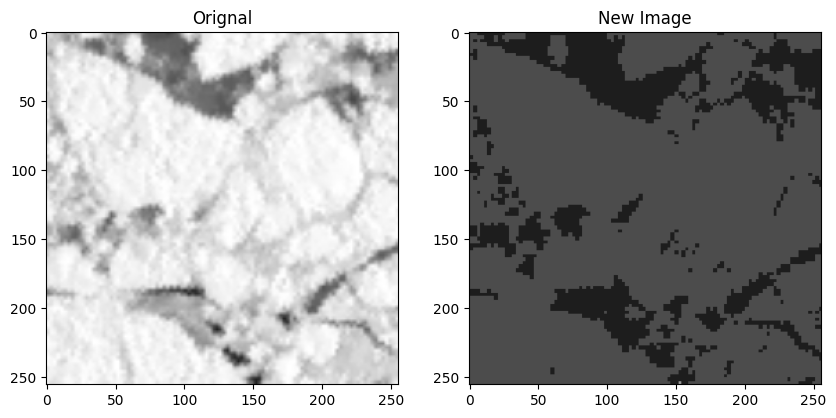

In [27]:
plot_image(train_images[1], train_masks[1])

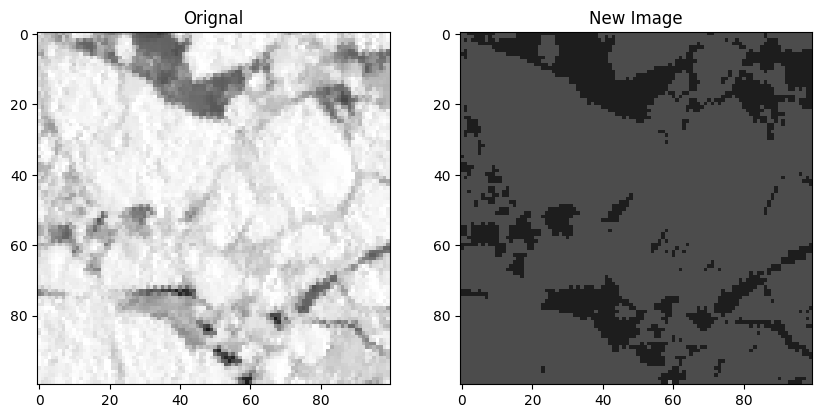

In [9]:
plot_image(train_images[1], train_masks[1])

In [28]:
###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)


/Users/nathan/miniconda3/envs/mml/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
np.unique(train_masks_encoded_original_shape)

array([0, 1, 2])

In [30]:
train_images.shape

(1000, 256, 256)

In [31]:
train_masks.shape

(1000, 256, 256)

In [32]:
#################################################
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [33]:
train_images.shape

(1000, 256, 256, 1)

In [34]:
train_masks_input.shape

(1000, 256, 256, 1)

In [35]:
#Selecting 20% for testing and remaining for training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size=0.20, random_state=0)

In [36]:

print("Class values in the dataset are ... ", np.unique(y_train))

Class values in the dataset are ...  [0 1 2]


In [37]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


In [38]:
train_masks_cat.shape

(800, 256, 256, 3)

In [39]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 256, 256,  │        160 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 256, 256,  │          0 │ conv2d_32[0][0]   │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 256, 256,  │      2,320 │ dropout_16[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 128, 128,  │          0 │ conv2d_33[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_10… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 128, 128,  │          0 │ conv2d_34[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_17[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 64, 64,    │          0 │ conv2d_35[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_11… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 64, 64,    │          0 │ conv2d_36[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_18[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 32, 32,    │          0 │ conv2d_37[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 32, 32,    │          0 │ conv2d_38[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 32, 32,    │    147,584 │ dropout_19[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 16, 16,    │          0 │ conv2d_39[0][0] 

 Total params: 7,775,347 (29.66 MB)

 Trainable params: 7,775,347 (29.66 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
import time

t0 = time.time()
history = model.fit(X_train, y_train_cat,
                    batch_size=16,
                    verbose=1,
                    epochs=20,
                    validation_data=(X_test, y_test_cat),
                    shuffle=False)
t1 = time.time()

total = t1-t0
print("time is ", total)

Epoch 1/20


/Users/nathan/miniconda3/envs/mml/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_70']. Received: the structure of inputs=*
  warnings.warn(


50/50 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.6823 - loss: 0.7208 - val_accuracy: 0.7297 - val_loss: 0.4510
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.8419 - loss: 0.3824 - val_accuracy: 0.9429 - val_loss: 0.1602
Epoch 3/20
16/50 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - accuracy: 0.9426 - loss: 0.1555

KeyboardInterrupt: 

In [ ]:
model.save('s2_multi_with_cloud_auto_labeled_100x100.keras')

#Evaluate the model
	# evaluate model
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")


26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 756ms/step - accuracy: 0.8995 - loss: 0.2595
Accuracy is =  90.08259773254395 %


In [23]:
##################################
#model = get_model()
model.load_weights('s2_multi_with_cloud_auto_labeled_50.keras')

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 771ms/step


In [24]:
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")
acc

26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 777ms/step - accuracy: 0.8995 - loss: 0.2595
Accuracy is =  90.08259773254395 %


0.9008259773254395

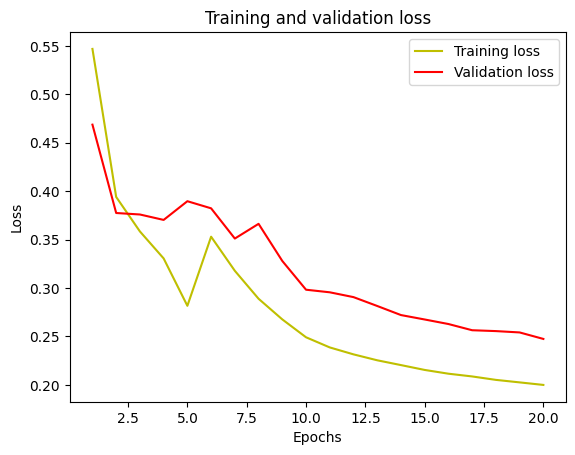

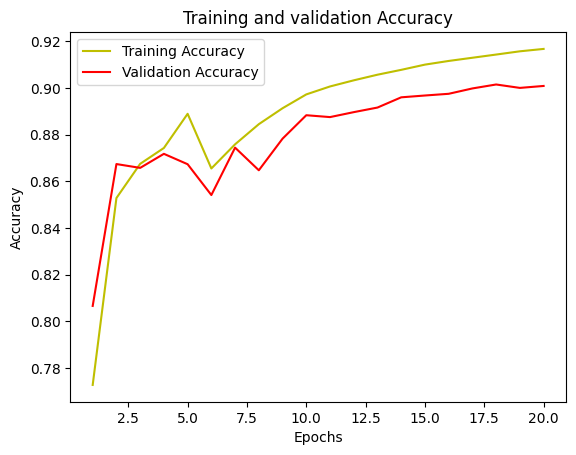

In [25]:
###
#plot the training and validation accuracy and loss at each epoch
# """
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [26]:

##################################
model = get_model()
model.load_weights('s2_multi_with_cloud_auto_labeled_50.hdf5')


#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

/Users/nathan/miniconda3/envs/mml/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_50']. Received: the structure of inputs=*
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 739ms/step


In [27]:
##################################################

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.86650246


[[9.5857500e+06 1.5688130e+06 6.1393000e+04]
 [6.3106900e+05 1.6777216e+07 2.1400000e+02]
 [4.6233500e+05 6.5712000e+04 9.1978460e+06]]
IoU for class1 is:  0.77873665
IoU for class2 is:  0.8810164
IoU for class3 is:  0.93975437


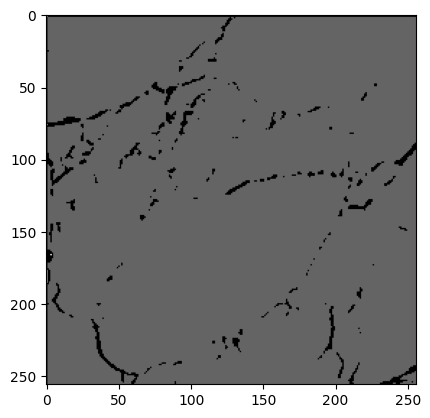

In [31]:
# #To calculate I0U for each class...
# values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
# print(values)
# class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[1,0]+ values[2,0])
# class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[0,1]+ values[2,1])
# class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[0,2]+ values[1,2])
# #class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

# print("IoU for class1 is: ", class1_IoU)
# print("IoU for class2 is: ", class2_IoU)
# print("IoU for class3 is: ", class3_IoU)
# #print("IoU for class4 is: ", class4_IoU)

# plt.imshow(train_images[0, :,:,0], cmap='gray')
# plt.imshow(train_masks[0], cmap='gray')

# Assuming IOU_keras is an instance of tf.keras.metrics.MeanIoU
confusion_matrix = IOU_keras.total_cm.numpy()
print(confusion_matrix)

class1_IoU = confusion_matrix[0,0] / (confusion_matrix[0,0] + confusion_matrix[0,1] + confusion_matrix[0,2] + confusion_matrix[1,0] + confusion_matrix[2,0])
class2_IoU = confusion_matrix[1,1] / (confusion_matrix[1,1] + confusion_matrix[1,0] + confusion_matrix[1,2] + confusion_matrix[0,1] + confusion_matrix[2,1])
class3_IoU = confusion_matrix[2,2] / (confusion_matrix[2,2] + confusion_matrix[2,0] + confusion_matrix[2,1] + confusion_matrix[0,2] + confusion_matrix[1,2])
# class4_IoU = confusion_matrix[3,3] / (confusion_matrix[3,3] + confusion_matrix[3,0] + confusion_matrix[3,1] + confusion_matrix[3,2] + confusion_matrix[0,3] + confusion_matrix[1,3] + confusion_matrix[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
# print("IoU for class4 is: ", class4_IoU)

plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


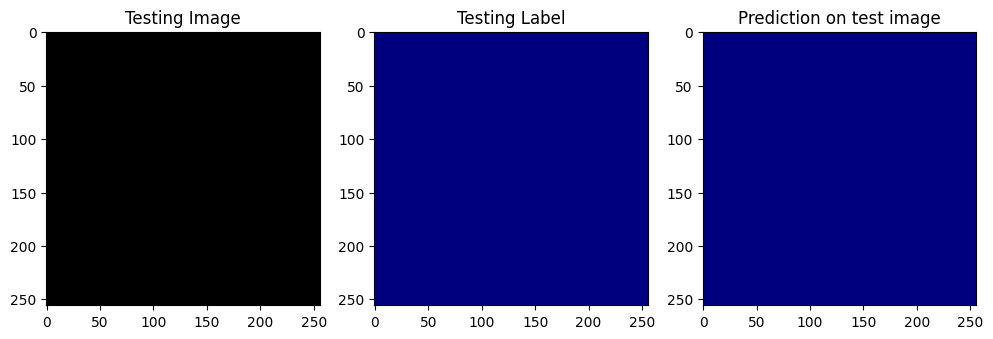

In [32]:
#######################################################################
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()


/Users/nathan/Documents/Files/Grad/UTSA/Courses/Thesis/mm-transformer-model/resized_images/train_images_4032


/Users/nathan/miniconda3/envs/mml/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/nathan/miniconda3/envs/mml/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_50']. Received: the structure of inputs=*
  warnings.warn(


mask shape  [0 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
[0 1 2]


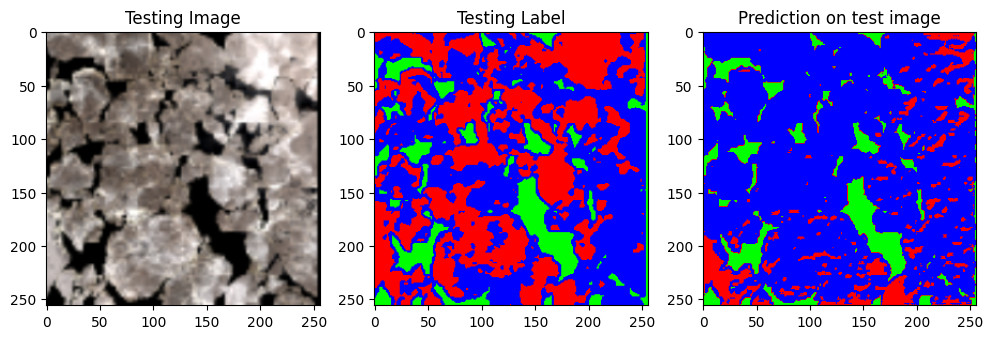

In [43]:
root_image = os.path.join(path1, "resized_images/train_images_4032")
#root_mask = "unet_multi_data/train_masks/"
root_mask = os.path.join(path1, "resized_images/train_masks_4032")
img_path = os.path.join(root_image, "s2_vis_65_1792_1792.png")
mask_path = os.path.join(root_mask, "s2_seg_65_1792_1792.png")
img = cv2.imread(img_path)
mask = cv2.imread(mask_path)

if img is None:
    raise FileNotFoundError(f"Image not found at {img_path}")
if mask is None:
    raise FileNotFoundError(f"Mask not found at {mask_path}")

mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask.shape
mask_reshaped = mask.reshape(-1,1)
mask_reshaped_encoded = labelencoder.fit_transform(mask_reshaped)
mask_encoded_original_shape = mask_reshaped_encoded.reshape(n, h, w)
print("mask shape ",np.unique(mask_encoded_original_shape))

test_img_norm=img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

print(np.unique(predicted_img))

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(mask,cmap="jet")
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap="brg")
plt.show()

#brg 0, 1, 2
#jet b g r

## Validation

## More than 10% cloud and shadow cover

In [ ]:
#Resizing images, if needed
SIZE_X = 256 #128 
SIZE_Y = 256 #128
n_classes = 3 #4 #Number of classes for segmentation

#Capture training image info as a list
val_images = []

for directory_path in glob.glob("unet_multi_data/val_shadow/"):
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        img = cv2.imread(img_path, 0)       
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
        val_images.append(img)
       
       
val_images = np.array(val_images)

#Capture mask/label info as a list
val_masks = [] 
for directory_path in glob.glob("unet_multi_data/val_shadow_mask/"):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        mask = cv2.imread(mask_path, 0)       
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        val_masks.append(mask)
        
#Convert list to array for machine learning processing          
val_masks = np.array(val_masks)

#print(np.unique(val_images))
np.unique(val_masks)

In [ ]:
###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = val_masks.shape
val_masks_reshaped = val_masks.reshape(-1,1)
val_masks_reshaped_encoded = labelencoder.fit_transform(val_masks_reshaped)
val_masks_encoded_original_shape = val_masks_reshaped_encoded.reshape(n, h, w)
np.unique(train_masks_encoded_original_shape)

In [ ]:
val_images.shape

In [ ]:
val_masks.shape

In [39]:
#################################################
val_images = np.expand_dims(val_images, axis=3)
val_images = normalize(val_images, axis=1)

val_masks_input = np.expand_dims(val_masks_encoded_original_shape, axis=3)

In [ ]:
val_images.shape

In [ ]:
val_masks_input.shape

In [42]:
## y_test ==> val_masks_input x_test=> val images
val_masks_cat = to_categorical(val_masks_input, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((val_masks_input.shape[0], val_masks_input.shape[1], val_masks_input.shape[2], n_classes))


In [ ]:
val_masks_cat.shape

In [ ]:
##################################
model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.load_weights('s2_multi_with_cloud.hdf5')
model.load_weights('s2_multi_with_cloud_auto_labeled_50.hdf5')
#model.load_weights('s2_multi_with_cloud_auto_labeled_100.hdf5')
#model.load_weights('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')  

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
#Evaluate the model
	# evaluate model
_, acc = model.evaluate(val_images, y_val_cat)
print("Accuracy is = ", (acc * 100.0), "%")


In [ ]:


import random

label = []
pred = []

for i in range(len(val_images)):
    val_img_number = i
    #random.randint(0, len(val_images))
    val_img = val_images[val_img_number]
    ground_truth=val_masks_input[val_img_number]
    val_img_norm=val_img[:,:,0][:,:,None]
    val_img_input=np.expand_dims(val_img_norm, 0)
    prediction1 = (model.predict(val_img_input))
    predicted_img1=np.argmax(prediction1, axis=3)[0,:,:]
    
    label += list(ground_truth[:,:,0].flatten())
    pred += list(predicted_img1.flatten())
    #print(label.shape)
    #break;
    '''
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(val_img[:,:,0], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='brg')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img1, cmap='brg')
    plt.show()
    '''
    
    
    #print(unet_fp[i])
    

In [ ]:
len(label)

In [ ]:
#brg = 0,1,2
#brg = 0, 1, 2
#blue 0 tice
#red 1 ice
#green 2 water

ice = label.count(1)
tice = label.count(0)
water = label.count(2)

print(ice, tice, water)

#ice = label.count(2)
#tice = label.count(1)
#water = label.count(0)
#print(ice, tice, water)

In [ ]:
import tensorflow as tf
tf.math.confusion_matrix(label, pred)

### List of Tensor Confusion Matrix

In [49]:
#confusion_matrix_list = []
#confusion_matrix_list.append(tf.math.confusion_matrix(label, pred).numpy())
#print(confusion_matrix_list)

In [ ]:
#########################################################333333333333
#------------->> refined

#Resizing images, if needed
SIZE_X = 256 #128 
SIZE_Y = 256 #128
n_classes = 3 #4 #Number of classes for segmentation

#Capture training image info as a list
val_images = []

for directory_path in glob.glob("unet_multi_data/val_ref/"):
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        img = cv2.imread(img_path, 0)       
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
        val_images.append(img)
       
       
val_images = np.array(val_images)

#Capture mask/label info as a list
val_masks = [] 
for directory_path in glob.glob("unet_multi_data/val_shadow_mask/"):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        mask = cv2.imread(mask_path, 0)       
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        val_masks.append(mask)
        
#Convert list to array for machine learning processing          
val_masks = np.array(val_masks)

#print(np.unique(val_images))
np.unique(val_masks)

###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = val_masks.shape
val_masks_reshaped = val_masks.reshape(-1,1)
val_masks_reshaped_encoded = labelencoder.fit_transform(val_masks_reshaped)
val_masks_encoded_original_shape = val_masks_reshaped_encoded.reshape(n, h, w)
np.unique(train_masks_encoded_original_shape)

val_images.shape

val_masks.shape

#################################################
val_images = np.expand_dims(val_images, axis=3)
val_images = normalize(val_images, axis=1)

val_masks_input = np.expand_dims(val_masks_encoded_original_shape, axis=3)

val_images.shape

val_masks_input.shape

## y_test ==> val_masks_input x_test=> val images
val_masks_cat = to_categorical(val_masks_input, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((val_masks_input.shape[0], val_masks_input.shape[1], val_masks_input.shape[2], n_classes))

val_masks_cat.shape

#Evaluate the model
	# evaluate model
_, acc = model.evaluate(val_images, y_val_cat)
print("Accuracy is = ", (acc * 100.0), "%")


#ori data

#######################################################################
#root = "unet_multi_data/val_new_mask/"
#root_val = "unet_multi_data/unet_res_ori/"
#unet_fp = []
#for fp in sorted(os.listdir(root)):
#    if fp.split(".")[-1].lower() in {"png"}:
#        unet_fp.append(root_val+fp)
            

import random

label = []
pred = []

for i in range(len(val_images)):
    val_img_number = i
    #random.randint(0, len(val_images))
    val_img = val_images[val_img_number]
    ground_truth=val_masks_input[val_img_number]
    val_img_norm=val_img[:,:,0][:,:,None]
    val_img_input=np.expand_dims(val_img_norm, 0)
    prediction1 = (model.predict(val_img_input))
    predicted_img1=np.argmax(prediction1, axis=3)[0,:,:]
    
    label += list(ground_truth[:,:,0].flatten())
    pred += list(predicted_img1.flatten())
    #print(label.shape)
    #break;
    '''
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(val_img[:,:,0], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='brg')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img1, cmap='brg')
    plt.show()

'''
#brg = 0,1,2
#brg = 0, 1, 2
#blue 0 tice
#red 1 ice
#green 2 water

ice = label.count(1)
tice = label.count(0)
water = label.count(2)

print(ice, tice, water)

#ice = label.count(2)
#tice = label.count(1)
#water = label.count(0)
#print(ice, tice, water)
tf.math.confusion_matrix(label, pred)


In [51]:
#confusion_matrix_list.append(tf.math.confusion_matrix(label, pred).numpy())
#print(confusion_matrix_list)

## Less than 10% cloud and shadow cover

In [ ]:
#########################################################333333333333
#------------->> shadow free

#Resizing images, if needed
SIZE_X = 256 #128 
SIZE_Y = 256 #128
n_classes = 3 #4 #Number of classes for segmentation

#Capture training image info as a list
val_images = []

for directory_path in glob.glob("unet_multi_data/val_shadow_free/"):
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        img = cv2.imread(img_path, 0)       
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
        val_images.append(img)
       
        
val_images = np.array(val_images)

#Capture mask/label info as a list
val_masks = [] 
for directory_path in glob.glob("unet_multi_data/val_shadow_free_mask/"):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        mask = cv2.imread(mask_path, 0)       
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        val_masks.append(mask)
        
#Convert list to array for machine learning processing          
val_masks = np.array(val_masks)

#print(np.unique(val_images))
np.unique(val_masks)

###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = val_masks.shape
val_masks_reshaped = val_masks.reshape(-1,1)
val_masks_reshaped_encoded = labelencoder.fit_transform(val_masks_reshaped)
val_masks_encoded_original_shape = val_masks_reshaped_encoded.reshape(n, h, w)
np.unique(train_masks_encoded_original_shape)

val_images.shape

val_masks.shape

#################################################
val_images = np.expand_dims(val_images, axis=3)
val_images = normalize(val_images, axis=1)

val_masks_input = np.expand_dims(val_masks_encoded_original_shape, axis=3)

val_images.shape

val_masks_input.shape

## y_test ==> val_masks_input x_test=> val images
val_masks_cat = to_categorical(val_masks_input, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((val_masks_input.shape[0], val_masks_input.shape[1], val_masks_input.shape[2], n_classes))

val_masks_cat.shape

#Evaluate the model
	# evaluate model
_, acc = model.evaluate(val_images, y_val_cat)
print("Accuracy is = ", (acc * 100.0), "%")


#ori data

#######################################################################
#root = "unet_multi_data/val_new_mask/"
#root_val = "unet_multi_data/unet_res_ori/"
#unet_fp = []
#for fp in sorted(os.listdir(root)):
#    if fp.split(".")[-1].lower() in {"png"}:
#        unet_fp.append(root_val+fp)
            

import random

label = []
pred = []

for i in range(len(val_images)):
    val_img_number = i
    #random.randint(0, len(val_images))
    val_img = val_images[val_img_number]
    ground_truth=val_masks_input[val_img_number]
    val_img_norm=val_img[:,:,0][:,:,None]
    val_img_input=np.expand_dims(val_img_norm, 0)
    prediction1 = (model.predict(val_img_input))
    predicted_img1=np.argmax(prediction1, axis=3)[0,:,:]
    
    label += list(ground_truth[:,:,0].flatten())
    pred += list(predicted_img1.flatten())
    #print(label.shape)
    #break;
    '''
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(val_img[:,:,0], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='brg')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img1, cmap='brg')
    plt.show()
    '''
#brg = 0,1,2
#brg = 0, 1, 2
#blue 0 tice
#red 1 ice
#green 2 water

ice = label.count(1)
tice = label.count(0)
water = label.count(2)

print(ice, tice, water)

#ice = label.count(2)
#tice = label.count(1)
#water = label.count(0)
#print(ice, tice, water)
tf.math.confusion_matrix(label, pred)




In [ ]:
array = tf.math.confusion_matrix(label, pred).numpy()
print(array)

In [54]:
#confusion_matrix_list.append(tf.math.confusion_matrix(label, pred).numpy())
#print(confusion_matrix_list)

In [ ]:
#########################################################333333333333
#------------->> shadow free ref

#Resizing images, if needed
SIZE_X = 256 #128 
SIZE_Y = 256 #128
n_classes = 3 #4 #Number of classes for segmentation

#Capture training image info as a list
val_images = []

for directory_path in glob.glob("unet_multi_data/val_shadow_free_ref/"):
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        img = cv2.imread(img_path, 0)       
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
        val_images.append(img)
       
       
val_images = np.array(val_images)

#Capture mask/label info as a list
val_masks = [] 
for directory_path in glob.glob("unet_multi_data/val_shadow_free_ref_mask/"):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        mask = cv2.imread(mask_path, 0)       
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        val_masks.append(mask)
        
#Convert list to array for machine learning processing          
val_masks = np.array(val_masks)

#print(np.unique(val_images))
np.unique(val_masks)

###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = val_masks.shape
val_masks_reshaped = val_masks.reshape(-1,1)
val_masks_reshaped_encoded = labelencoder.fit_transform(val_masks_reshaped)
val_masks_encoded_original_shape = val_masks_reshaped_encoded.reshape(n, h, w)
np.unique(train_masks_encoded_original_shape)

val_images.shape

val_masks.shape

#################################################
val_images = np.expand_dims(val_images, axis=3)
val_images = normalize(val_images, axis=1)

val_masks_input = np.expand_dims(val_masks_encoded_original_shape, axis=3)

val_images.shape

val_masks_input.shape

## y_test ==> val_masks_input x_test=> val images
val_masks_cat = to_categorical(val_masks_input, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((val_masks_input.shape[0], val_masks_input.shape[1], val_masks_input.shape[2], n_classes))

val_masks_cat.shape

#Evaluate the model
	# evaluate model
_, acc = model.evaluate(val_images, y_val_cat)
print("Accuracy is = ", (acc * 100.0), "%")


#ori data

#######################################################################
#root = "unet_multi_data/val_new_mask/"
#root_val = "unet_multi_data/unet_res_ori/"
#unet_fp = []
#for fp in sorted(os.listdir(root)):
#    if fp.split(".")[-1].lower() in {"png"}:
#        unet_fp.append(root_val+fp)
            

import random

label = []
pred = []

for i in range(len(val_images)):
    val_img_number = i
    #random.randint(0, len(val_images))
    val_img = val_images[val_img_number]
    ground_truth=val_masks_input[val_img_number]
    val_img_norm=val_img[:,:,0][:,:,None]
    val_img_input=np.expand_dims(val_img_norm, 0)
    prediction1 = (model.predict(val_img_input))
    predicted_img1=np.argmax(prediction1, axis=3)[0,:,:]
    
    label += list(ground_truth[:,:,0].flatten())
    pred += list(predicted_img1.flatten())
    #print(label.shape)
    #break;
    '''
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(val_img[:,:,0], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='brg')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img1, cmap='brg')
    plt.show()
    '''
#brg = 0,1,2
#brg = 0, 1, 2
#blue 0 tice
#red 1 ice
#green 2 water

ice = label.count(1)
tice = label.count(0)
water = label.count(2)

print(ice, tice, water)

#ice = label.count(2)
#tice = label.count(1)
#water = label.count(0)
#print(ice, tice, water)
tf.math.confusion_matrix(label, pred)




# Confusion Matrix

## Confusion Matrix Cloudy and Shadowy

In [44]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

# 1st row water ground truth
# 2nd row thin ice ground truth
# 3rd row thick ice ground truth

#array =[[1000943,   77081,   10272],
#       [ 798431, 5751404,       2],
#       [  56723,    1823,  691929]]

array = [[ 956127,  127567,    4602],
        [ 557494, 5992343,       0],
        [  64385,    1873,  684217]]

df_cm = pd.DataFrame(array, range(3), range(3))
#plt.figure(figsize=(5,3))
a = ["Thin Ice", "Thick Ice", "Open water"]
df_cm = pd.DataFrame(array, index = [i for i in a],
              columns = [i for i in a])

#sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
#            fmt='.2%', cmap='Blues')
df_cm_sum = df_cm.sum(axis = 1)
print(df_cm_sum)
sn.set(font_scale=1.1) # for label size

df_cm['Thin Ice'] = df_cm['Thin Ice']/df_cm_sum
df_cm['Thick Ice'] = df_cm['Thick Ice']/df_cm_sum
df_cm['Open water'] = df_cm['Open water']/df_cm_sum

#print(df_cm['Open water'])

sn.heatmap(df_cm, annot=True, fmt='.2%', annot_kws={"size": 16}, cmap="Blues") # font size

plt.xlabel("Predicted Label")
plt.ylabel("Target Ground Truth Label")

plt.suptitle("Confusion Matrix for Cloudy-Shadowy data")
plt.show()

ModuleNotFoundError: No module named 'seaborn'

: 

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

# 1st row water ground truth
# 2nd row thin ice ground truth
# 3rd row thick ice ground truth


#array =[[1000943,   77081,   10272],
#       [ 798431, 5751404,       2],
#       [  56723,    1823,  691929]]

array = [[1056241,   30059,    1996],
        [  36148, 6513687,       2],
        [  23035,       0,  727440]]

df_cm = pd.DataFrame(array, range(3), range(3))
#plt.figure(figsize=(5,3))
a = ["Thin Ice", "Thick Ice", "Open water"]
df_cm = pd.DataFrame(array, index = [i for i in a],
              columns = [i for i in a])

#sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
#            fmt='.2%', cmap='Blues')
df_cm_sum = df_cm.sum(axis = 1)
print(df_cm_sum)
sn.set(font_scale=1.1) # for label size
df_cm['Thin Ice'] = df_cm['Thin Ice']/df_cm_sum
df_cm['Thick Ice'] = df_cm['Thick Ice']/df_cm_sum
df_cm['Open water'] = df_cm['Open water']/df_cm_sum

#print(df_cm['Open water'])

sn.heatmap(df_cm, annot=True, fmt='.2%', annot_kws={"size": 16}, cmap="Blues") # font size

plt.xlabel("Predicted Label")
plt.ylabel("Target Ground Truth Label")

plt.suptitle("Confusion Matrix for Cloud-Shadow Filtered")
plt.show()